# Pitt–Peters Tutorial for Forward Analysis

In this tutorial, we use the Pitt–Peters dynamic inflow model to evaluate the rotor performance of an arbitrary rotor at six flow conditions. The flow is parallel to the rotor disk (i.e., edgewise flow), which corresponds to how a helicopter would operate. 

We first import all relevant sub-modules and start the `CSDL` recorder.

In [1]:
import csdl_alpha as csdl
from BladeAD.utils.var_groups import RotorAnalysisInputs, RotorMeshParameters
from BladeAD.core.airfoil.zero_d_airfoil_model import ZeroDAirfoilModel, ZeroDAirfoilPolarParameters
from BladeAD.core.pitt_peters.pitt_peters_model import PittPetersModel
from BladeAD.utils.plot import make_polarplot
import numpy as np
import matplotlib.pyplot as plt


# Start CSDL recorder
recorder = csdl.Recorder(inline=True)
recorder.start()


Next up is the discretization. 
1. `num_nodes` refers to the number of analysis points. The idea is to **leverage vectorization** rather than writing a `for loop`. In this tutorial, we will look at multiple six flow speeds starting from 0 m/s up to 50 m/s
2. `num_radial` refers to the number of radial stations (i.e., blade elements). It is recommended to use at least 20 radial stations. In this tutorial, we will use 35 in order to provide a high-resolution visualization at the end.
3. `num_azimuthal` refers to the number of discretization points in the azimuthal (i.e., tangential) direction. Since we are considering edgewise flow in this tutorial (i.e., the flow is parallel to the rotor disk), the **inflow will not be axisymmetric** since the advancing side of the rotor experiences a higher inflow velocity relative to the retreating side. This leads to a variation of the rotor load in the azimuthal direction.

In [2]:
# Discretization
num_nodes = 6 # In this example, we evaluate the model at 6 different flow speeds
num_radial = 35
num_azimuthal = 40 # For edgewise flow, set num_azimuthal we need an azimuthal discretization

num_blades = 2

Next, we set up the airfoil model. In this tutorial, we will use a simple 1D airfoil model where the lift and drag polars are only in terms of the sectional angle of attack. To $C_l$ model will be assumed linear and the $C_d$ model quadratic. Parameters like $C_{l_{0}}$ or $C_{d_{0}}$ can be read off an airfoil polar (e.g., generated by `XFOIL`). The airfoil model uses the Viterna method (see Background section) to extrapolate the prediction of the $C_l$ and $C_d$ to $\pm90^{\circ}$, which is necessary to account for sections of the blade that may be stalled. After setting up the airfoil model, we visualiz the polar.  

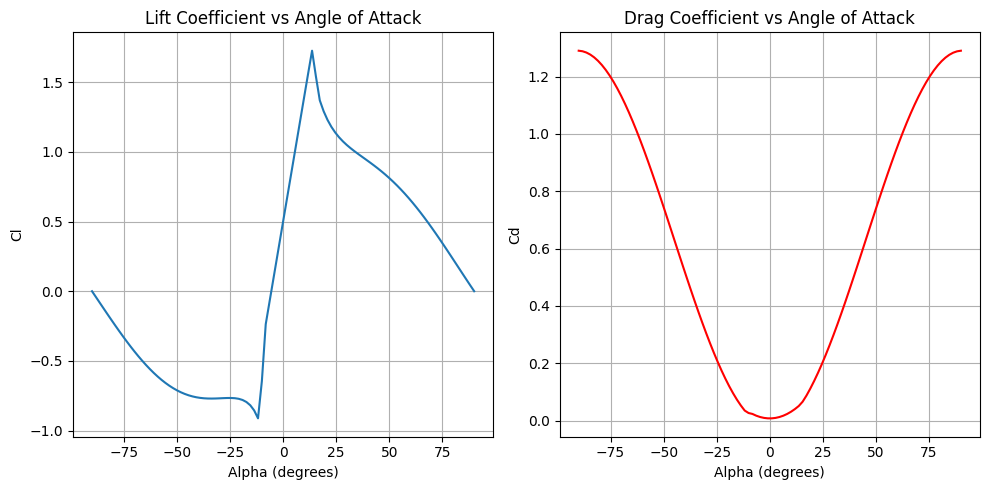

In [11]:
# Simple 1D airfoil model
# Specify polar parameters
polar_parameters = ZeroDAirfoilPolarParameters(
    alpha_stall_minus=-10.,
    alpha_stall_plus=15.,
    Cl_stall_minus=-1.,
    Cl_stall_plus=1.5,
    Cd_stall_minus=0.02,
    Cd_stall_plus=0.06,
    Cl_0=0.5,
    Cd_0=0.008,
    Cl_alpha=5.1566,
)
# Create airfoil model
airfoil_model = ZeroDAirfoilModel(
    polar_parameters=polar_parameters,
)

# Evaluate and visualiza the airfoil model
alpha = np.deg2rad(np.linspace(-90, 90, 100)) # Angle of attack in radians
Cl, Cd = airfoil_model.evaluate(alpha=alpha, Re=1e6, Ma=0.1)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot Cl vs alpha
axs[0].plot(np.rad2deg(alpha), Cl.value, label='Cl')
axs[0].set_xlabel('Alpha (degrees)')
axs[0].set_ylabel('Cl')
axs[0].set_title('Lift Coefficient vs Angle of Attack')
axs[0].grid(True)

# Plot Cd vs alpha
axs[1].plot(np.rad2deg(alpha), Cd.value, label='Cd', color='r')
axs[1].set_xlabel('Alpha (degrees)')
axs[1].set_ylabel('Cd')
axs[1].set_title('Drag Coefficient vs Angle of Attack')
axs[1].grid(True)

plt.tight_layout()
plt.show()

Now, we set up the rotor analysis inputs. First, we define the following "mesh" parameters.
1. `thrust_vector`: this the **normal vector** of the rotor disk (Recall that thrust, by convention, is normal to the rotor disk). It's important to note that the coordinate system is based on the flight-dynamics reference frame (of the aircraft), in which $x$ is positive toward the nose of the aircraft, $y$ is positive toward the right wing, and $z$ is positive downward. This means that for this tutorial, orienting the disk parallel to the flow means that our thrust vector is $[0, 0, -1]$
2. `thrust_origin`: the center of the rotor hub with respect to some reference point like the aircraft's center of gravity. This is only necessary when we're interested in computing the aerodynamic moment due to thrust about the reference point.
3. `chord_profile`: the chord distribution in the span-wise direction of the blade. This can be either specified directly (i.e., `np.array`), through an imported file (e.g., `.txt` or `.csv`), or indirectly through a `BsplineParameterization` (not covered in this tutorial, see API references). The shape of the chord profile must be `(num_radial, )`
4. `twist_profile`: the twist distribution (in radian) in the span-wise direction of the blade. The specification and required shape is analogous to the chord profile
5. `radius`: the total radius of the rotor (note that the normalized hub radius is spcified later)
6. `mesh_velocity`: the (inflow) velocity at the rotor hub in terms of the $u, v, w$ components of the free stream velocity with respect to the flight dynamics reference frame. Here the shape is `(num_nodes, 3)`. **In most cases, just specifying $u$ or $w$ is sufficient**. In this tutorial, we only specify $u$ to simulate the edgewise flow. If we had set up the thrust vector as $[1, 0, 0]$, we would achieve edgewise flow by only specifying $w$.
7. `rpm`: the rotor speed in revolutions per minute.

Other inputs to `RotorMeshParameters` are `num_radial`, `num_azimuthal`, `num_blades`, and `norm_hub_radius`, which is 0.2 by default.

In [12]:
# Set up rotor analysis inputs
# 1) thrust (unit) vector and origin (origin is the rotor hub location and only needed for computing moments)
thrust_vector=csdl.Variable(name="thrust_vector", value=np.array([0., 0., -1.])) # Thrust vector in the negative z-direction (up)
thrust_origin=csdl.Variable(name="thrust_origin", value=np.array([0. ,0., 0.]))

# 2) Rotor geometry 
# chord and twist profiles (linearly varying from root to tip)
chord_profile=csdl.Variable(name="chord_profile", value=np.linspace(0.25, 0.05, num_radial))
twist_profile=csdl.Variable(name="twist_profile", value=np.linspace(np.deg2rad(50), np.deg2rad(20), num_radial)) # Twist in RADIANS
# Radius of the rotor
radius = csdl.Variable(name="radius", value=1.2)

# 3) Mesh velocity: vector of shape (num_nodes, 3) where each row is the 
# free stream velocity vector (u, v, w) at the rotor center
# In this example we consider a linearly spaced range of flow speeds from 0 to 50 m/s 
# The flow will be in the x-direction i.e., parallel to the rotor disk
mesh_vel_np = np.zeros((num_nodes, 3))
mesh_vel_np[:, 0] = np.linspace(0., 50, num_nodes) # Free stream velocity in the x-direction
mesh_velocity = csdl.Variable(value=mesh_vel_np)
# Rotor speed in RPM
rpm = csdl.Variable(value=2000 * np.ones((num_nodes,)))

# 4) Assemble inputs
# mesh parameters
bem_mesh_parameters = RotorMeshParameters(
    thrust_vector=thrust_vector,
    thrust_origin=thrust_origin,
    chord_profile=chord_profile,
    twist_profile=twist_profile, 
    radius=radius,
    num_radial=num_radial,
    num_azimuthal=num_azimuthal,
    num_blades=num_blades,
    norm_hub_radius=0.2,
)
# rotor analysis inputs
inputs = RotorAnalysisInputs(
    rpm=rpm,
    mesh_parameters=bem_mesh_parameters,
    mesh_velocity=mesh_velocity,
)

Now we are ready to instantiate the solver class `PittPetersModel` and run the solver by calling the `evaluate` method. The solver class takes in the number of nodes, the airfoil model, and the integration scheme, which is `trapezoidal` by default. The integration scheme refers to the numerical integration scheme used for integrating spanwise quantities like $dT$ or $dQ$. Other options for the integration scheme are `Riemann` and `Simpson`. The `evaluate` method has two arguments: `inputs` and `ref_point`, the latter of which is set to $[0, 0, 0]$ by default.

In [13]:
# Instantiate and run Pitt--Peters model
pitt_peters_model = PittPetersModel(
    num_nodes=num_nodes,
    airfoil_model=airfoil_model,
    integration_scheme='trapezoidal',
)

pitt_peters_outputs = pitt_peters_model.evaluate(inputs=inputs)

/Users/mariusruh/Desktop/packages/lsdo/CSDL_alpha/csdl_alpha/src/operations/tensor/expand.py:184: UserWarning: "action" will have no effect when expanding a scalar.
  warnings.warn('"action" will have no effect when expanding a scalar.')


nonlinear solver: gs_nlsolver converged in 29 iterations.
nonlinear solver: gs_nlsolver converged in 29 iterations.
nonlinear solver: gs_nlsolver converged in 29 iterations.
nonlinear solver: gs_nlsolver converged in 29 iterations.
nonlinear solver: gs_nlsolver converged in 28 iterations.
nonlinear solver: gs_nlsolver converged in 28 iterations.


Lastly, we print some of the scalar-valued quantities and plot the sectional thrust profile $dT$ over the rotor disk for each flow velocity. The `evaluate` method returns a `dataclass` of output values that are easily accessible for post-processing or setting objectives or constraints. For plotting the distribution of $dT$ we use the built-in helper function `make_polarplot`.

Scalar Outputs:
Total thrust: [3432.12687906 3432.79784554 3452.64315096 3505.95694602 3585.3308005
 3679.07009328]
Total torque: [802.62325757 803.00080985 808.50206341 821.78168026 842.46617027
 867.65302237]
Thrust coefficient: [0.00980325 0.00980517 0.00986185 0.01001414 0.01024085 0.0105086 ]
Torque coefficient: [0.00740452 0.007408   0.00745876 0.00758127 0.00777209 0.00800445]




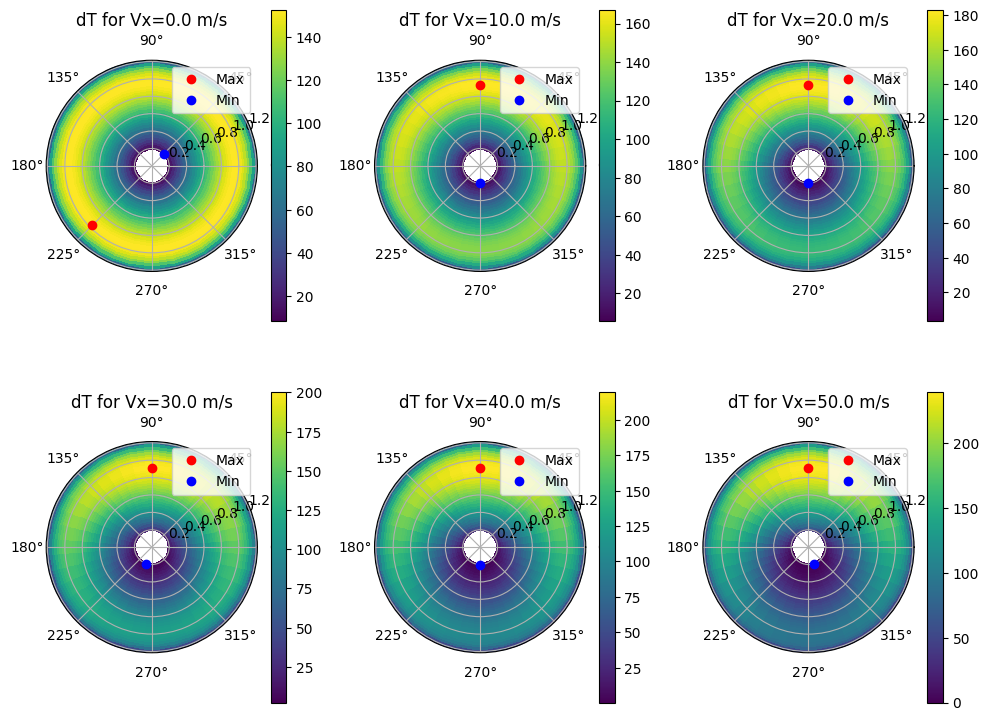

In [14]:
# Print scalar outputs
print("Scalar Outputs:")
print(f"Total thrust: {pitt_peters_outputs.total_thrust.value}")
print(f"Total torque: {pitt_peters_outputs.total_torque.value}")
print(f"Thrust coefficient: {pitt_peters_outputs.thrust_coefficient.value}")
print(f"Torque coefficient: {pitt_peters_outputs.torque_coefficient.value}")
print("\n")

# Plot the sectional thrust distrubution over the rotor disk
make_polarplot(
    pitt_peters_outputs.sectional_thrust,
    radius=radius,
    quantity_name=[f"dT for Vx={v} m/s" for v in mesh_vel_np[:, 0]],
    plot_contours=False,
)